### Prep work station

In [1]:
# Import the necessary libraries
# Note: some library imports may be incompatible with Jupyter Notebooks

%matplotlib inline
!pip install category_encoders
!pip install eli5
!pip install pdpbox
!pip install plotly
!pip install xgboost

import category_encoders as ce
import eli5
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

from eli5.sklearn import PermutationImportance
from pdpbox import pdp
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier, XGBRegressor

### Data Wrangling

In [2]:
df = pd.read_csv('Kickstarter.csv')

In [3]:
df.describe() #search for outliers

# features with outliers: backers_count, converted_pledged_amount, 
#                        fx_rate, goal -> backers_count and goal
# proposed dependent feature (y - success): converted_pledged_amount/goal 
#                       (requires drop of all pledged features, state)
# potential non-unique features (drop): pledged, usd_pledged, currency,
#                       currency_symbol (conflicts with other features)
# low-variable features (drop): id, static_usd_rate, fx_rate, urls,
#                                source_urls,
# features to revisit with domain knowledge (drop): all datetimes 
#           (created_at, deadline, launched_at, state_changed_at)
# What's left?: ['backers_count', 'blurb', 'category', 'country' 
#               'goal', 'slug', 'spotlight', 'staff_pick', 'y']


,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,id,launched_at,pledged,state_changed_at,static_usd_rate,usd_pledged
count,3745.000000,3.745000e+03,3.745000e+03,3.745000e+03,3745.000000,3.745000e+03,3.745000e+03,3.745000e+03,3.745000e+03,3.745000e+03,3745.000000,3.745000e+03
mean,124.187984,3.340863e+04,1.458710e+09,1.465817e+09,1.222676,3.652195e+04,1.075979e+09,1.462987e+09,1.446430e+04,1.465653e+09,1.016216,1.268122e+04
std,573.219201,9.314629e+05,6.497385e+07,6.448361e+07,5.187837,3.370224e+05,6.214294e+08,6.446828e+07,1.472494e+05,6.437578e+07,0.235868,1.393683e+05
min,0.000000,0.000000e+00,1.248920e+09,1.251778e+09,0.009443,1.000000e+00,5.268700e+04,1.248922e+09,0.000000e+00,1.251778e+09,0.008782,0.000000e+00
25%,3.000000,8.500000e+01,1.414460e+09,1.423275e+09,1.000000,1.500000e+03,5.414901e+08,1.420575e+09,9.000000e+01,1.423275e+09,1.000000,8.500000e+01
50%,23.000000,1.228000e+03,1.458682e+09,1.465761e+09,1.000000,5.000000e+03,1.074172e+09,1.462724e+09,1.235000e+03,1.465737e+09,1.000000,1.228000e+03
75%,81.000000,6.051000e+03,1.513765e+09,1.520790e+09,1.000000,1.500000e+04,1.618201e+09,1.518114e+09,6.266000e+03,1.520706e+09,1.000000,6.025000e+03
max,23999.000000,5.440614e+07,1.565492e+09,1.570933e+09,127.661342,1.000000e+07,2.146773e+09,1.565798e+09,7.850867e+06,1.565815e+09,1.715913,7.850867e+06


In [4]:
# df.country.value_counts() -> stick with one: US (has the most data)
# df.isnull().sum() 
# features to drop: friends, is_backing, is_starred, permissions

In [5]:
#using cross-validation -> train/test splits/holdouts made later on  

In [6]:
def return_category(x): 
    res = json.loads(x)
    out = res['name']
    return(out)

def wrangle(X): 
    """ function to wrangle/pre-process the data in df """
    X = X.copy()
    
    X['success'] = (X['converted_pledged_amount']/X['goal'])
    
    # keep important features - revisit with slug and blurb
    X = X[['backers_count', 'category', 'country', 
              'goal', 'spotlight', 'staff_pick', 'success']]
    
    # retieve names of categories
    X['category'] = X['category'].apply(return_category)
    
    # enumerate boolean string types - or not - may break the model
    # X[['spotlight', 'staff_pick']] = X[['spotlight', 'staff_pick']].astype(int)

    # query - control for country
    X = X.query('country == "US"')

    # managing outliers
    X = X.query('backers_count < 750')
    X = X.query('goal < 350000')
    X = X.query('success <= 3')
    
    # convert to categorical; for relative measure of preformance..
    X['success'] = pd.qcut(X.success, 10, labels = [
                          10, 9, 8, 7, 6, 5,
                          4, 3, 2, 1])
    
    #drop any remaining rows/entries containing one or more nan
    X = X.dropna()

    return X

df2 = wrangle(df)
y = pd.DataFrame()
y['success'] = (df2['success'])
X = df2.drop(columns = ['success','country','category'])
X.head(3) # there should be four features: 1(int), 1(float), 2(bool)

,backers_count,goal,spotlight,staff_pick
0,103,5000.0,True,True
1,318,24042.0,True,True
4,17,2500.0,True,False


### Exploratory Visuals 1

In [73]:
fig = px.scatter(df2, x="goal", y="success")
fig.update_layout(title_text="Goal Amount vs. Success")

fig.update_xaxes(title_text = "goal (USD)")
fig.update_yaxes(range=[10.5, 1])

fig.show();

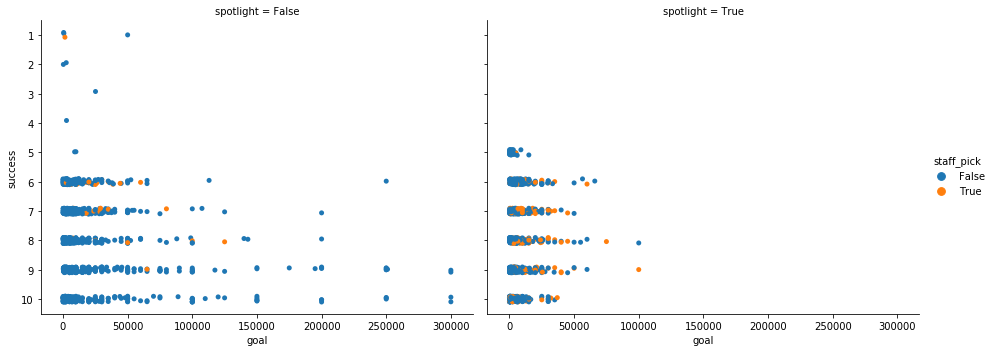

In [44]:
plt = sns.catplot(x='goal', y='success', hue='staff_pick', 
                 data=df2, row=None, col='spotlight', 
                 col_wrap=None, ci=95, n_boot=1000, units=None,  
                 ##, kind = '', ## 
                 height=5, aspect=1.3, 
                 orient=None, color=None, palette=None, 
                 legend=True, legend_out=True, sharex=True, 
                 sharey=True, margin_titles=False)
    
## kind = “point”, “bar”, “strip”, “swarm”, “box”, “violin”, “boxen” ##

Interpretation of above plot(s): 

1) There is higher variability in goal amounts among the comparatively less-successful campaigns; 

2) Those campaigns with a spotlight status of 'True' are simultaneously more comparatively successful and consist of more modest goals; 

3) There appear to be no top-tier campaigns (with regards to their comparative success) that are also spotlighted. 


Extra hypothesis: Spotlight status is reserved for less-competitive, perhaps mid-tier, campaigns as a means of (temporarily) boosting their odds of success. 

In [75]:
# Now analyze another set of features
fig = px.scatter(df2, x="backers_count", y="success")
fig.update_layout(title_text="Number of Backers vs. Success")

fig.update_yaxes(range=[10.5, 1])

fig.show();

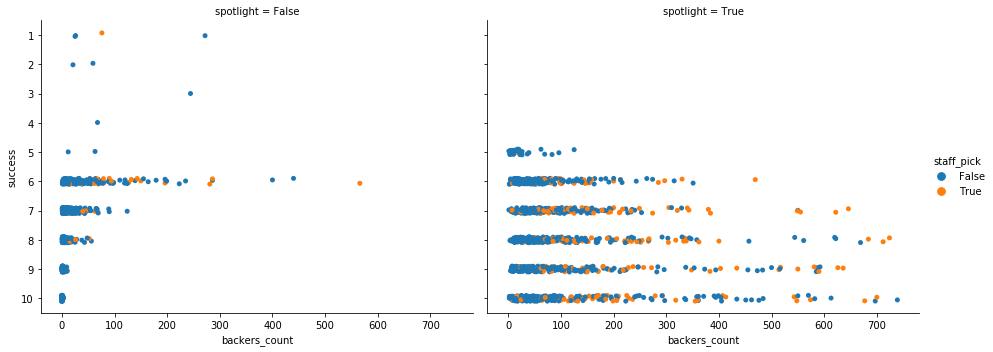

In [52]:
plot = sns.catplot(x='backers_count', y='success', hue='staff_pick', 
                 data=df2, row=None, col='spotlight', 
                 col_wrap=None, ci=95, n_boot=1000, units=None,  
                 ##, kind = '', ## 
                 height=5, aspect=1.3, 
                 orient=None, color=None, palette=None, 
                 legend=True, legend_out=True, sharex=True, 
                 sharey=True, margin_titles=False)


Interpretation of above plot(s): 

1) In general, the number of backers appears to be positively correlated with the comparative success of a campaign. 

2) In the case of a spotlight status of 'True', there is higher variability in the number of backers among the comparatively less-successful campaigns; 

3) There appears to be a greater proportion of campaigns that are staff_picks among the spotlighted group, with neither the number of backers nor comparative success appearing to influence what campaign becomes a staff-pick; 

4) In the un-spotlighted group, the number of backers seems positively correlated with success up to a point, with success improving (from 10 to 6) as the distribution in the number of backers becomes less concentrated (at the low-end). 

In [80]:
# Plot to check for relation between the continuous features
fig = px.scatter(df2, x="goal", y="backers_count", title='Backers and Goals')
fig.show();

# Backers seem to invariably favor the comparatively more modest goals

In [110]:
# Table to check for relation between the continuous features
#pd.crosstab(df2['spotlight'], df2['staff_pick'], normalize = 1)
pd.crosstab(df2['spotlight'], df2['staff_pick'], normalize = 0)

# When staff_pick is true, there is a greater proportion
#  of campaigns that are spotlighted. 
# Spotlight status has little bearing on staff_pick status. 

staff_pick,False,True
spotlight,,
False,0.962585,0.037415
True,0.800844,0.199156


### Establish Baseline and Train/Test Split

In [113]:
y['success'].value_counts(normalize = True)
# baseline: .110

6     0.109699
10    0.101652
1     0.099958
2     0.099958
3     0.099958
4     0.099958
7     0.099958
8     0.099958
9     0.098687
5     0.090216
Name: success, dtype: float64

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1888, 4), (473, 4), (1888, 1), (473, 1))

### Exploratory Visuals 2

In [115]:
# Prep data for use with Partial Dependence Plots (PDPs)
# to help interpret feature importances 
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train)
model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_encoded, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

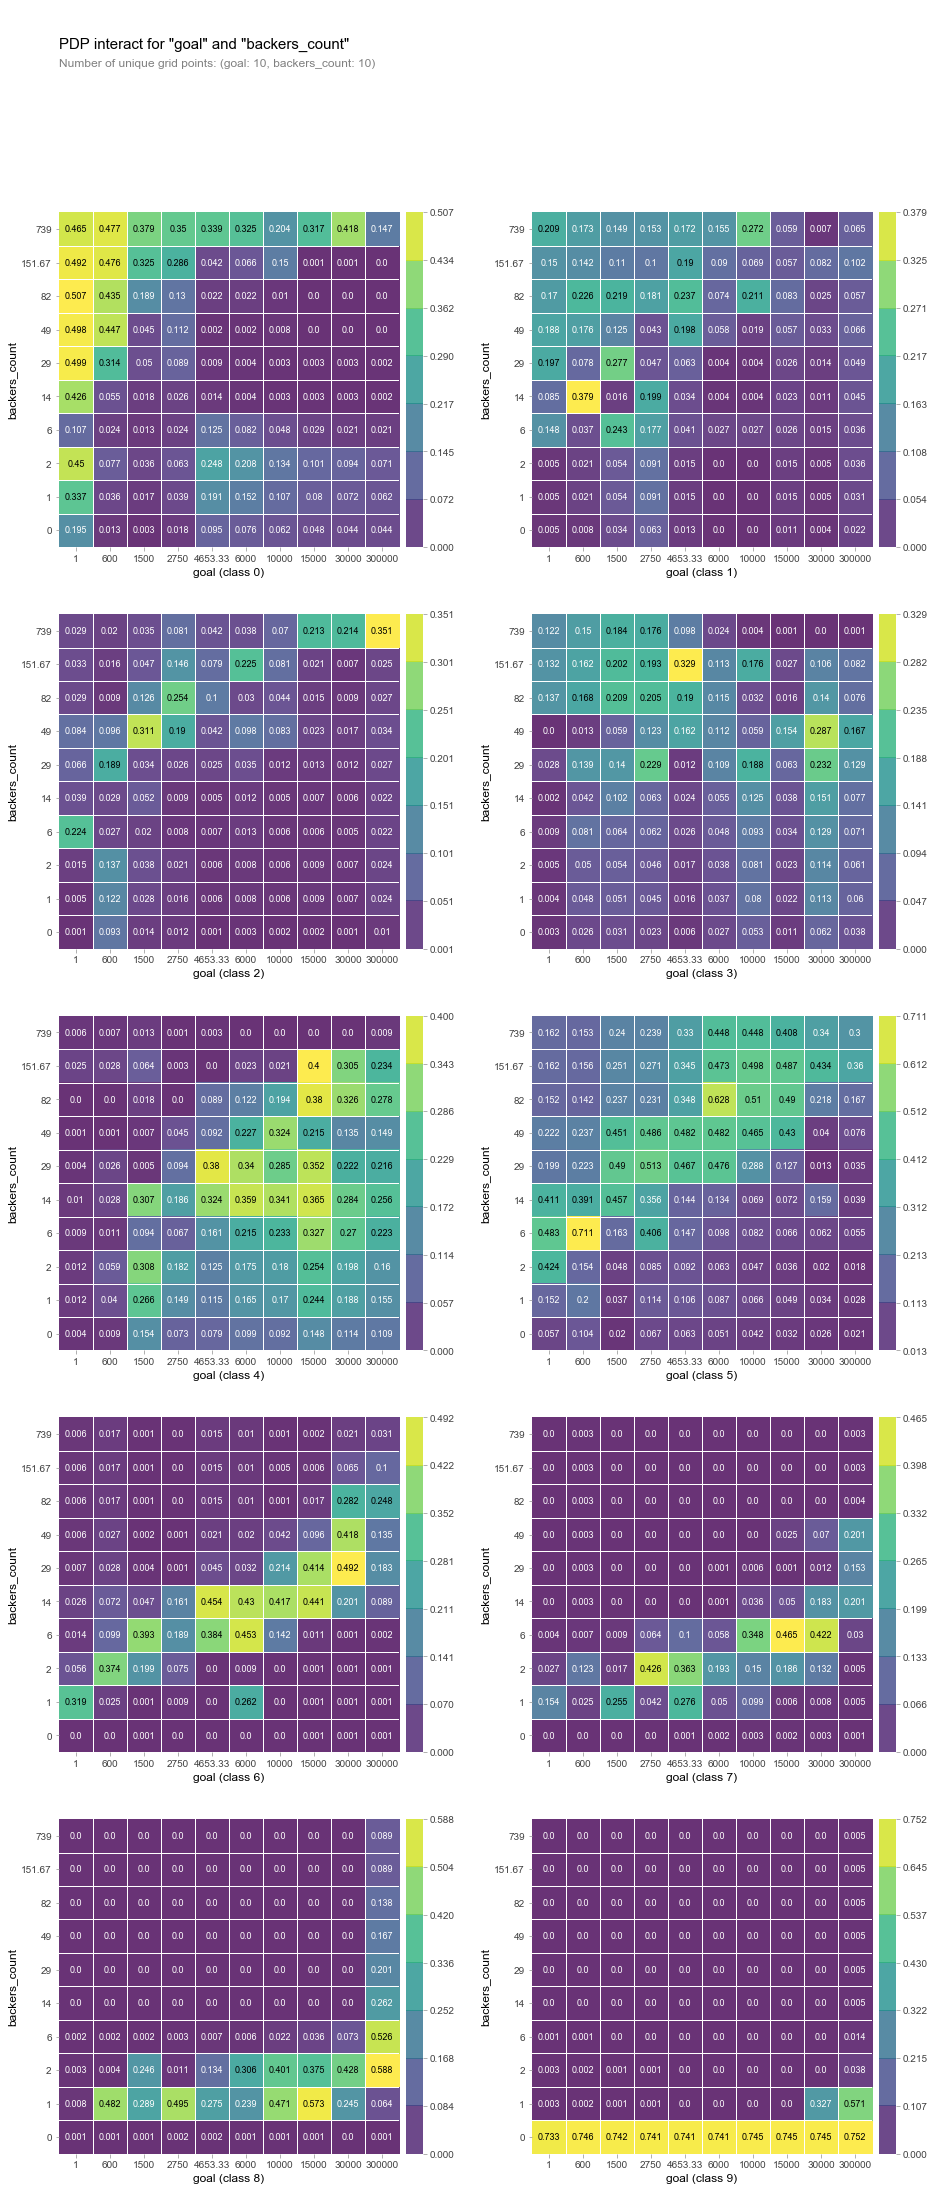

In [116]:
# Compare two explanatory/independent features 
features = ['goal', 'backers_count']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
    )

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# Plots represent how two features interact 
# to affect the target-value predicted, across
# the range of target categories

Interpretation of the above PDP group: feature interaction (between backers_count and goal) is most apparent for the lowest and highest success categories. In the case of the lowest success category (see "class 9"), a low backers_count (of 0) interacts very-strongly with goal to affect a campaign's success. The connection might become evident with a level of domain knowledge. 

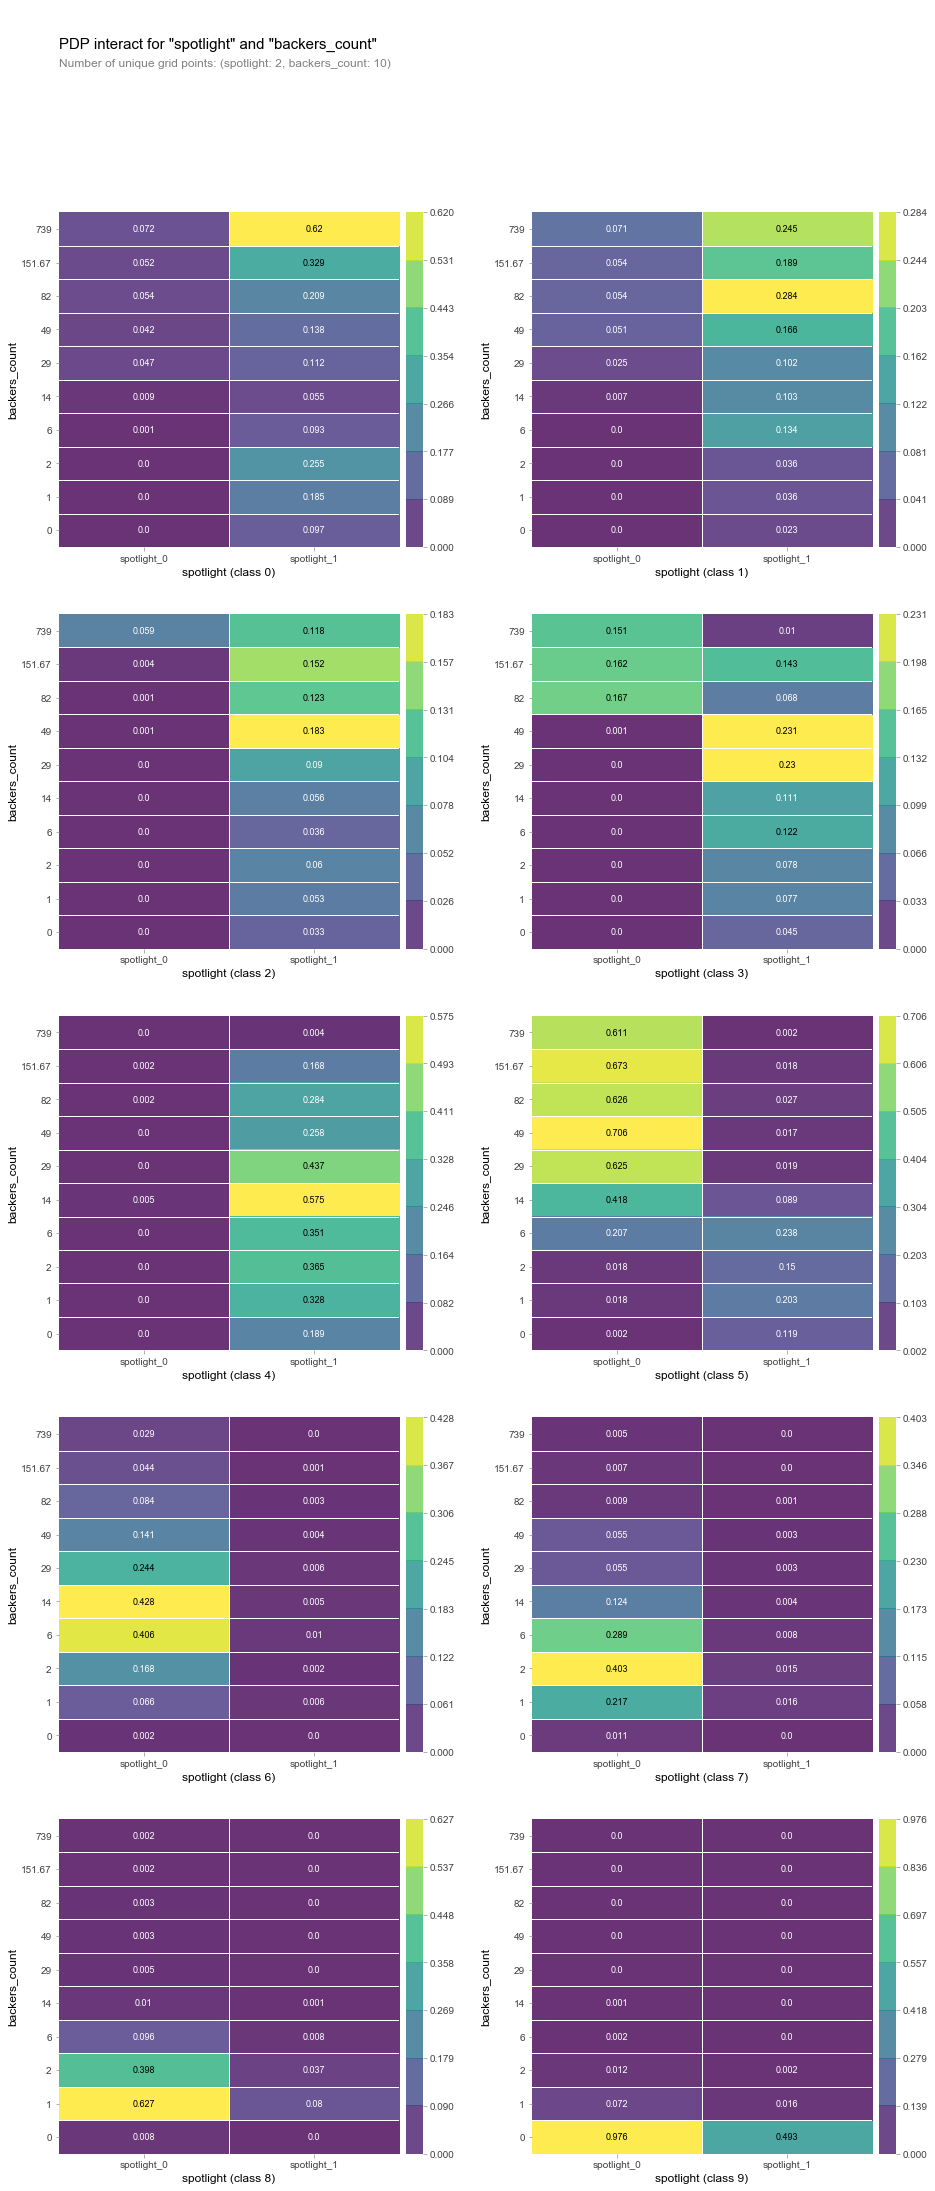

In [118]:
# PDP for another set of features
features = ['spotlight', 'backers_count']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
    )

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Feature Importance: Permutation 

In [11]:
# Define the model and fit the train data
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'))

X_train_transformed = transformers.fit_transform(X_train)
X_test_transformed = transformers.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# Instantiate the permuter and fit to test data 
permuter = PermutationImportance(
    model,
    scoring='accuracy', 
    n_iter=2, 
    random_state=42)

permuter.fit(X_test_transformed, y_test)
feature_names = X_test.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names)

# Interpreting permutation output: values at top are most important feats
#"The first number in each row shows how much model performance decreased with a random shuffling.
# The number after the ± measures how performance varied from one-reshuffling to the next.
# You'll occasionally see negative values for permutation importances. In those cases, 
# the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. 
# This happens when the feature didn't matter (should have had an importance close to 0), 
# but random chance caused the predictions on shuffled data to be more accurate. 
# This is more common with small datasets, like the one in this example, 
# because there is more room for luck/chance." source:
# https://www.kaggle.com/dansbecker/permutation-importance

Weight,Feature
0.2526 ± 0.0021,backers_count
0.1533 ± 0.0106,spotlight
0.0877 ± 0.0106,goal
0.0095 ± 0.0106,staff_pick


### Exploring Models: XG-BOOST
Accuracy score (test): 0.457

In [12]:
# Make a model and fit it to your train set
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=1, 
                  n_jobs=-1))

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='multi:softprob', random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
        

In [13]:
# Check accuracy of fitted model
print('Test Accuracy', pipeline.score(X_test, y_test))

Test Accuracy 0.45665961945031713


### Exploring Models: Random Forest Classifier
Accuracy score (test): 0.423

In [14]:
# Make a pipeline to set up the model
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1))

# Fit on train, score on test
pipeline.fit(X_train,y_train)
print('Validation Accuracy:', pipeline.score(X_test,y_test))

# Get accuracy score for Test-set
print('Test Accuracy:', pipeline.score(X_test, y_test))

Validation Accuracy: 0.42283298097251587
Test Accuracy: 0.42283298097251587


In [15]:
# Cross-validation method (optional)
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1,
                           random_state=42))

k = 5 # represents the number of cross-validations to be run
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')

print(f'Accuracy Score for {k} folds:', scores)
print('Average Score', np.mean(scores))

Accuracy Score for 5 folds: [0.46858639 0.45144357 0.43915344 0.45066667 0.45430108]
Average Score 0.45283022761545666


### Formalizing the Model


In [16]:
# Get the best model - opting for Random Forest here.
# Behind-the-curtain trail-and-error gives reason
# for favoring Regressor over Classifier..

# Instantiate the model, make a random grid
rf = RandomForestRegressor(random_state = 42)
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': ([int(x) for x in np.linspace(10, 110, num = 11)]),
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)

model = rf_random.fit(X_train, y_train)

print(rf,random_grid)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False) {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [17]:
# Get the final score - 0.859 (using Regressor)
print(model.score(X_test,y_test))

0.8587854154812052


In [18]:
# Save and prep the model for export
filename = '20191021_rfc_86.sav'
filename_pkl = '20191021_rfc_86.pkl'
pickle.dump(model, open(filename_pkl,'wb'))

In [19]:
# Make an inference using a fabricated entry
import json

to_test = '''{"backers_count": 100000, "goal": 0.01, "spotlight": 1, "staff_pick": 1}'''
testa = json.loads(to_test)
print(testa) # should look like json

{'backers_count': 100000, 'goal': 0.01, 'spotlight': 1, 'staff_pick': 1}


In [20]:
testa_df = pd.DataFrame.from_records(testa, index=[0])
testa_df # format should look familiar

,backers_count,goal,spotlight,staff_pick
0,100000,0.01,1,1


### Interpreting the Output

In [21]:
# Get a prediction for above inference
model.predict(testa_df.to_numpy())

array([1.24542844])

Output = 4.829; Inputs = {'backers_count': 5, 'goal': 50000.0, 'spotlight': 1, 'staff_pick': 0}. What does this mean? Recall that the model being used is a Regressor and that the y-vector's unique values were mapped as integers, from 1 to 10, representing deciles. This means that the output is a float, from 1 to 10, with a higher value indicating a lower comparative performance of a given Kickstarter campaign. For example, higher inputs for goal will increase the output. Alternatively, higher inputs for the backers_count field will yield a lower result. The functionality of the model is limited to the defined ranges of the input fields and are as follow; backers_count: 0 to 750, goal: 0 to 350000.00 (USD), spotlight: 1 or 0, staff_pick: 1 or 0. Holding all other inputs constant, a goal of 500000.00(USD) will yield the same result as a goal of 4500000.00(USD). 

An output of 4.0 would indicate that, for the provided inputs, a campaign would perform in the fourth decile; that compared to all other campaigns, its performance would range from the top-49 to the top-40 percentile (or top 49-40%). To be in the top-10%, spotlight and staff_pick status are essential. A campaign with a goal of 0.01(USD) will likely not perform well with respect to other campaigns. 